In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
from scipy.stats import norm

from functions import *

In [3]:
data = pd.read_pickle('near_far_df.pkl')
data['index'] = np.arange(0,len(data), 1)

## Data Analysis

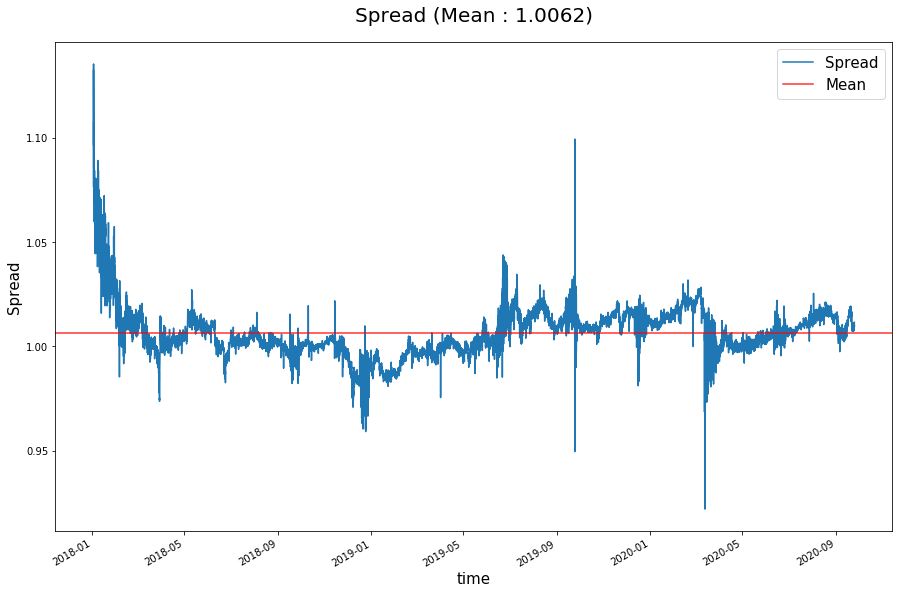

In [4]:
plt.figure(figsize=(15,10))
plt.title('Spread (Mean : {0:.4f})'.format(data['spread'].mean()), fontsize=20, pad=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Spread', fontsize=15)
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=20)
data['spread'].plot(label='Spread')
plt.axhline(data['spread'].mean(), c='r', alpha=0.8, label='Mean')
plt.legend(fontsize=15)
plt.show()

In [5]:
## ADF : 데이터의 Stationarity를 평가하는 지표. y의 증분을 y(t-1)값으로 회귀한 회귀 계수가 1인지를 검정.
## p-value는 유의수준 0.00001 기각된다. 즉, 데이터는 Stationarity가 강하고, Mean Reversion을 이용한 전략을 사용할 수 있다는 근거가 된다.

adfuller_test = adfuller(data['spread'], autolag= "t-stat")
print("ADF test statistic: {0:.4f}".format(adfuller_test[0]))
print("p-value: {0:.7f}".format(adfuller_test[1]))

ADF test statistic: -5.8804
p-value: 0.0000003


# #Mean Reversion
## 1. Mean Reversion Strategy :  평균으로의 회귀 현상을 이용한 전략을 말한다. 장기 가격 수준에서 위쪽이나 아래쪽으로 이탈했을 때 다시 평균으로 회귀할 것을 예상한 포지션을 취하는 전략이다.

# #Implementation
## 1. Bollinger Band : Spread(Far Price / Near Price)의 n기간 이동평균선에 k(상수) * n기간 표준편차를 더하여 Upper Limit, k(상수) *n기간 표준편차를 차감하여 Lower Limit을 설정. 
$$ Upper Limit = SpreadMA(n) + k * SpreadSTD(n) $$
$$ Lower Limit = SpreadMA(n) - k * SpreadSTD(n) $$

## 2. Entry
## - Upper Limit을 위로 돌파 :  Long near, Short Far Position(Spread 축소 예상)
## - Lower Limit을 아래로 돌파 : Short Near, Long Far Position(Spread 확대 예상)
## 3. Out
## - 포지션에서 진입한 상태에서 n일 이동평균선 수준으로 Spread가 돌아올 때 청산.

# #Parameter
## 1. n, k : n은 이동평균선 산출기간, k는 Upper, Lower Limit을 정할 때 표준편차에 곱해주는 계수.
## 2. Rollover : 근월물 만기가 오기 몇 시간 전에 Rollover를 할 것인가 결정.

## 3. Leverage : 근월물과 원월물 포지션의 비중을 정해졌다고 가정했을 때, 레버리지를 얼마나 사용할 것인가를 결정. 변동 레버리지(1/spread의 분산에 비례) 또는 고정 레버리지를 사용할 것인지 결정 (**Backtest 상으로는 가격이 꾸준하게 상승하는 것으로 나와서 적절한 레버리지 수준을 설정하기가 어려움. 결론적으로 항상 수익을 얻을 수 있다면 가능한한 큰 레버리지를 사용함으로써 최대의 수익을 얻을 수 있음.)


# #Metric
## 1. Ret : 최종 수익률
## 2. Std : 표준편차
## 3. Sharpe Ratio : Ret/Std

# #Performance
## 1. 큰 손실없이 꾸준히 증가. 큰 손실구간이 없으므로 레버리지를 크게 가져갈 수 있다.
## 2. Parameter를 변경해도 그래프의 형태가 유사하기 때문에 강건한 모형이라고 볼 수 있다.
## 3. N, K를 높일수록 진입과 청산의 숫자가 감소한다. 즉, 수익이 좀 더 확실하게 느껴질 때에만 포지션에 진입한다. 따라서 Losing Trade 숫자를 줄임으로써 수익을 얻는다.

# #Limitation
## 1. Leverage : 꾸준히 증가하는 형태의 그래프에서 최적의 레버리지를 어떻게 설정할지 결정하지 못했다. spread의 n기간 분산에 반비례하는 레버리지를 설정해보았다. 그런데 수익 측면이나 변동성 측면 모두 결과가 더 나빠졌다. 그래서 레버리지를 일단 고정하였다. 최선의 레버리지를 설정할 수 있을지 더 고민해볼 필요가 있다.

## 2. 체결 실패 : 근월물과 원월물 포지션에 진입할 때 한 쪽 주문이 일부만 체결된 때 어떻게 해야할 것인지 고민. 일부만 체결된 포지션에 맞춰서 수량을 조절하거나, 두 주문 다 취소하는 방법이 있다. 어떤 전략이 유용한지 테스트해보지 못함. 

## 일부만 체결된 포지션에 맞춰서 수량을 조절해야 하는 경우는 Trade가 많지 않아서 한 번의 기회를 놓치는 것이 수익에 큰 영향을 줄 수 있는 경우이다.
## 주문을 취소하지 않을 때의 단점은 수량 조절 과정에서 bis-ask spread만큼의 비용이 바로 발생한다는 점이 있다, 전략적인 레버리지 비율이 변경될 수 있다는 점이 있다.

## 주문을 놓치는 케이스가 얼마나 발생할지에 대한 데이터가 있어야 수치적으로 검증할 수 있을 것으로 보인다. 직관적으로 생각해보기에는 최적화된 전략이 Trade 횟수가 많지 않으므로 일부 체결만 되더라도 포지션에 진입해야 할 것으로 보인다.

## 포지션에 점진적으로 진입하는 방법으로 이를 해결할 수 있으나, 충분한 스프레드를 얻지 못하게 되고, Rebalancing이 잦아지면 수수료 비용이 커질 수 있다는 문제점이 있다. 그래서 점진적으로 진입하는 방식은 고려대상에서 제외 하였다.

# Bollinger Band Strategy : Example

In [6]:
## Example
## Timing 전략
n = 650
k = 1.28
port = bollinger_str(n,k,data)

## Rollover 전략
port['rollover_out'] = rollover_out(data, period=24*5)

## Leverage 전략
port['leverage'] = np.ones(len(port))
  
## Backtest
ret, std, sharpe_ratio, result = backtest(data, port, commission=0.00075)
trades = trade_result(result)

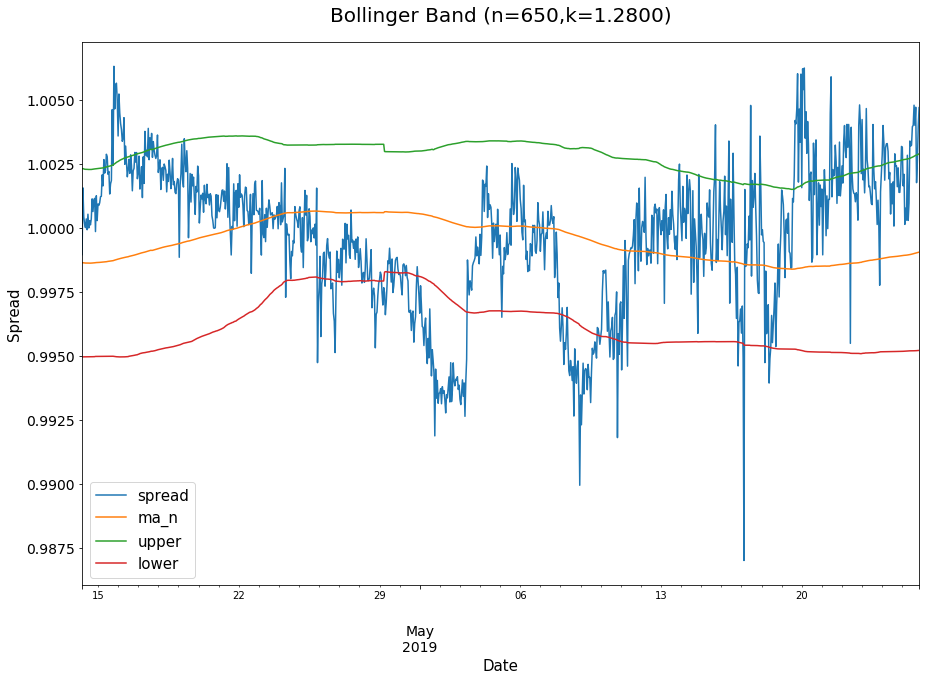

In [7]:
bollinger_graph(result, n=n, k=k, sample_start=12000, sample_end=13000)

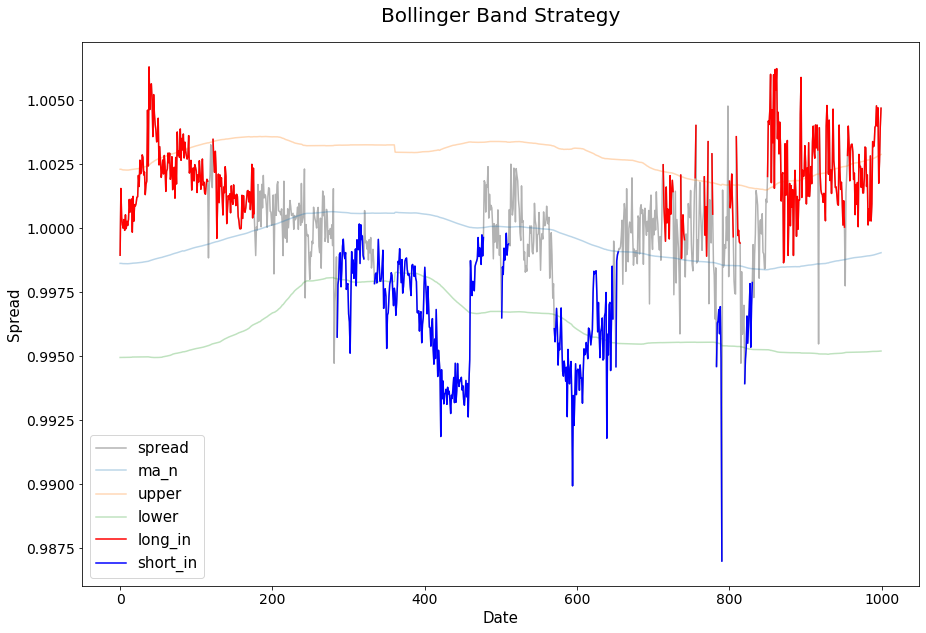

In [8]:
## 빨간선은 Long_in(Long Near, Short Far), 파란선은 Short_in(Short Fear, Long Far) position에 있는 상태
strategy_graph(result, sample_start = 12000, sample_end = 13000)

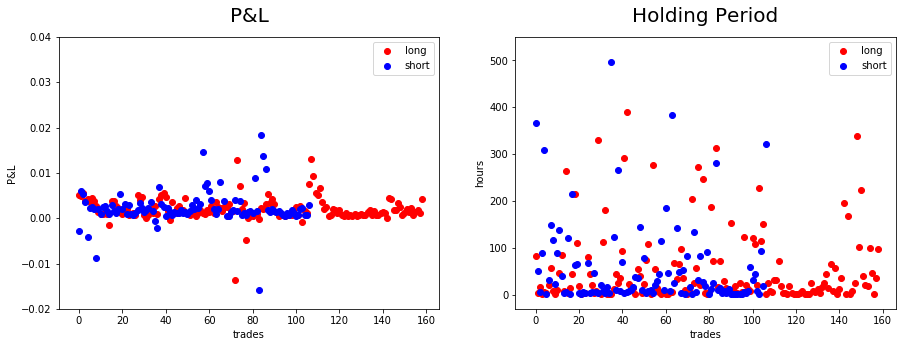

In [9]:
## Long trade(Long Near, Short Far)와 Short trade(Short Fear, Long Far)별 P&L과 Holding Period
trade_graph(trades)

# Parameter Optimization

# N : 이동평균 기간
# K : Upper, Lower Limit을 만들 때 쓰이는 계수 
### 이동평균으로부터의 오차가 정규분포를 따른다고 가정하면, 표준정규분포의 Z_alpha 값을 K로 사용했을 때 Entry timing이 전체 기간 중 (1-alpha)만큼 발생할 것으로 가정하는 것이다. 
# Rollover : 근월물 만기가 오기 얼마 전에 rollover를 할 것인가

In [10]:
## Grid 설정
n_grid = [50, 250, 450, 650]
k_grid = [norm.ppf(0.7).round(2), norm.ppf(0.8).round(2), norm.ppf(0.9).round(2)]
rollover_grid = [24*i for i in [1,5,10]]

grids = []
for n in n_grid:
    for k in k_grid:
        for rollover in rollover_grid:
            grids.append((n, k, rollover))

print('Total Grid Number : {0}'.format(len(grids)))

Total Grid Number : 36


In [11]:
## Grid 별로 탐색 후 결과 저장
metrics = []
total_time = 0
balance = pd.DataFrame()
for i,grid in enumerate(grids):
    start = time()
    ## Parameter
    n, k, rollover = grid 
    port = bollinger_str(n,k, data)
    port['rollover_out'] = rollover_out(data, period=rollover)
    
    ## Leverage = 1로 일정하게 설정
    port['leverage'] = np.ones(len(port))
        
    ## Backtest 결과 도출
    ret, std, sharpe_ratio, result = backtest(data,port, commission=0.00075)
    balance[grid] = result['bal_t']
    metrics.append([ret, std, sharpe_ratio]) ## 결과 저장
    
    ## 실행시간 측정
    running_time = time()-start
    total_time += running_time
    exp_time = (len(grids) - i - 1) * running_time / 60
    print('{0}번째 Iteration에 소요된 시간 : {1:.4f}초, 총 소요시간 : {2:.4f}초, 예상 소요시간 : {3:.4f}분'
          .format(i+1, running_time, total_time, exp_time))
    
## Backtest 결과 저장
grid_df = pd.DataFrame(grids, columns = ['n', 'k', 'rollover'])
metric_df = pd.DataFrame(metrics, columns=['ret','std','sharpe_ratio'])
compare = pd.concat([grid_df, metric_df], axis=1)

1번째 Iteration에 소요된 시간 : 6.6150초, 총 소요시간 : 6.6150초, 예상 소요시간 : 3.8588분
2번째 Iteration에 소요된 시간 : 5.1646초, 총 소요시간 : 11.7796초, 예상 소요시간 : 2.9266분
3번째 Iteration에 소요된 시간 : 3.8047초, 총 소요시간 : 15.5843초, 예상 소요시간 : 2.0926분
4번째 Iteration에 소요된 시간 : 3.1834초, 총 소요시간 : 18.7677초, 예상 소요시간 : 1.6978분
5번째 Iteration에 소요된 시간 : 3.9013초, 총 소요시간 : 22.6690초, 예상 소요시간 : 2.0157분
6번째 Iteration에 소요된 시간 : 3.7838초, 총 소요시간 : 26.4527초, 예상 소요시간 : 1.8919분
7번째 Iteration에 소요된 시간 : 3.0628초, 총 소요시간 : 29.5155초, 예상 소요시간 : 1.4804분
8번째 Iteration에 소요된 시간 : 4.7907초, 총 소요시간 : 34.3062초, 예상 소요시간 : 2.2356분
9번째 Iteration에 소요된 시간 : 6.3765초, 총 소요시간 : 40.6827초, 예상 소요시간 : 2.8694분
10번째 Iteration에 소요된 시간 : 5.3144초, 총 소요시간 : 45.9971초, 예상 소요시간 : 2.3029분
11번째 Iteration에 소요된 시간 : 6.2962초, 총 소요시간 : 52.2933초, 예상 소요시간 : 2.6234분
12번째 Iteration에 소요된 시간 : 5.9291초, 총 소요시간 : 58.2224초, 예상 소요시간 : 2.3717분
13번째 Iteration에 소요된 시간 : 3.8031초, 총 소요시간 : 62.0255초, 예상 소요시간 : 1.4579분
14번째 Iteration에 소요된 시간 : 3.4829초, 총 소요시간 : 65.5084초, 예상 소요시간 : 1.2771분
15번째 Iteration에 

In [12]:
## Return, Standard Deviation, Sharpe Ratio의 최대, 최소 보기
metric_summary(compare)

# of grid : 36
Max Return : 0.6019, Parameter : N=250.0, K=1.28, Rollover=24.0
Min Return : -0.6734, Parameter : N=50.0, K=0.52, Rollover=240.0


Max Sharpe Ratio : 6.4168, Parameter : N=50.0, K=1.28, Rollover=120.0
Min Sharpe Ratio : -2.7216, Parameter : N=50.0, K=0.52, Rollover=24.0


Min Standard Deviation : 0.0319, Parameter : N=250.0, K=0.52, Rollover=24.0
Max Standard Deviation : 0.2516, Parameter : N=50.0, K=0.52, Rollover=240.0


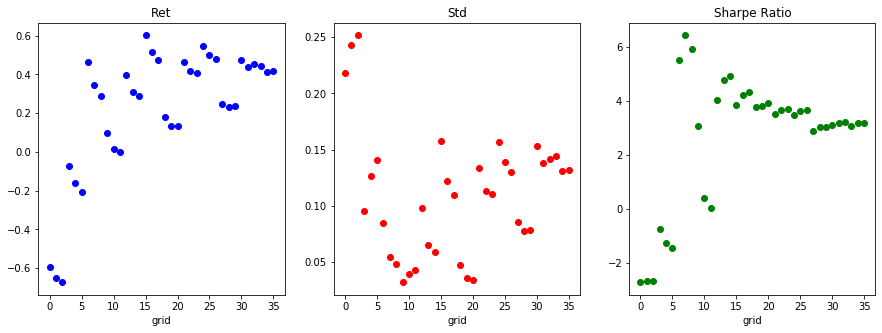

In [13]:
## Grid 별 Ret, Std, Sharpe Ratio의 분포
metric_graph(compare)

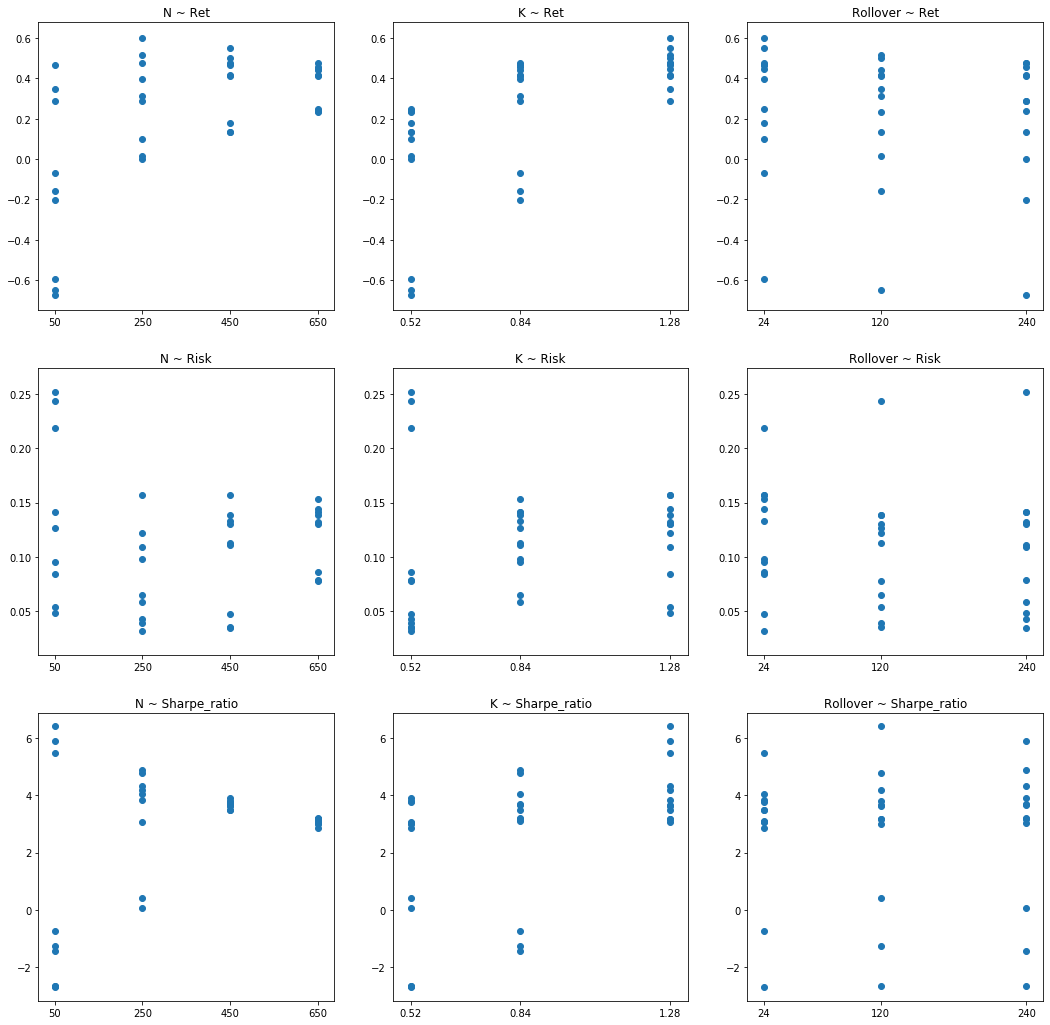

In [14]:
## Parameter 변화에 따른 Metric들의 Sensitivity
sensitive_graph(compare, n_grid, k_grid, rollover_grid)

# Backtest Result 

## 1. n, k가 증가할수록 Parameter 변화에 따른 Return, Sharpe Ratio의 분산이 작아진다.
###  - n이 증가하면 upper, lower limit이 평행선에 가까워지고, k가 커지면 upper, lower limit이 멀어진다. 따라서 n과 k가 증가할수록 Entry timing이 줄어들기 때문에 Trade 횟수를 줄인다. 대신 확실한 수익기회에 진입하는 전략이 된다.
### - n과 k가 작을 때 Return과 Sharpe Ratio가 매우 높은 경우가 있는데, 이는 Overfitting의 결과일 수 있다. n과 k가 작을수록 parameter 변화에 따라 metric 변동이 심하므로, 시장 상황이 바뀌었을 때 동일한 수익을 준다는 보장이 없다. 

## 2. k가 증가할수록 Return, Sharpe Ratio가 증가하는 경향이 있다.
### - n>=650, k>=1.28인 경우 Return, Sharpe Ratio가 거의 일정하게 나온다.

## 3. Standard Deviation은 Parameter 변화에 따른 특별한 경향은 보이지 않는다.

## 4. Rollover 기간은 큰 영향을 주지 못하는 것으로 보인다.

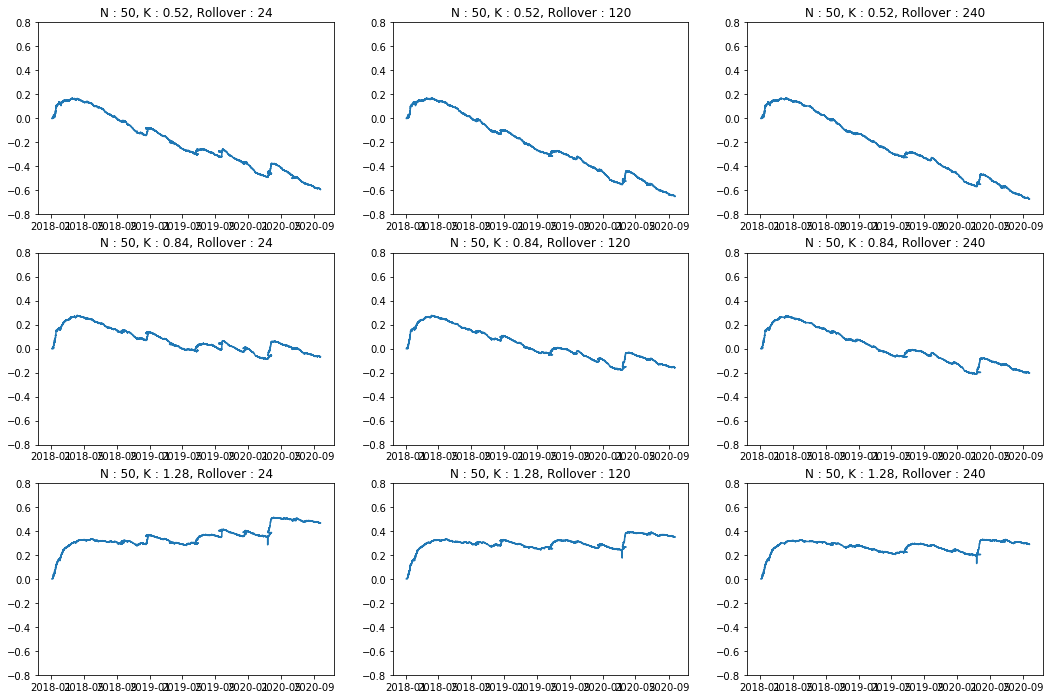

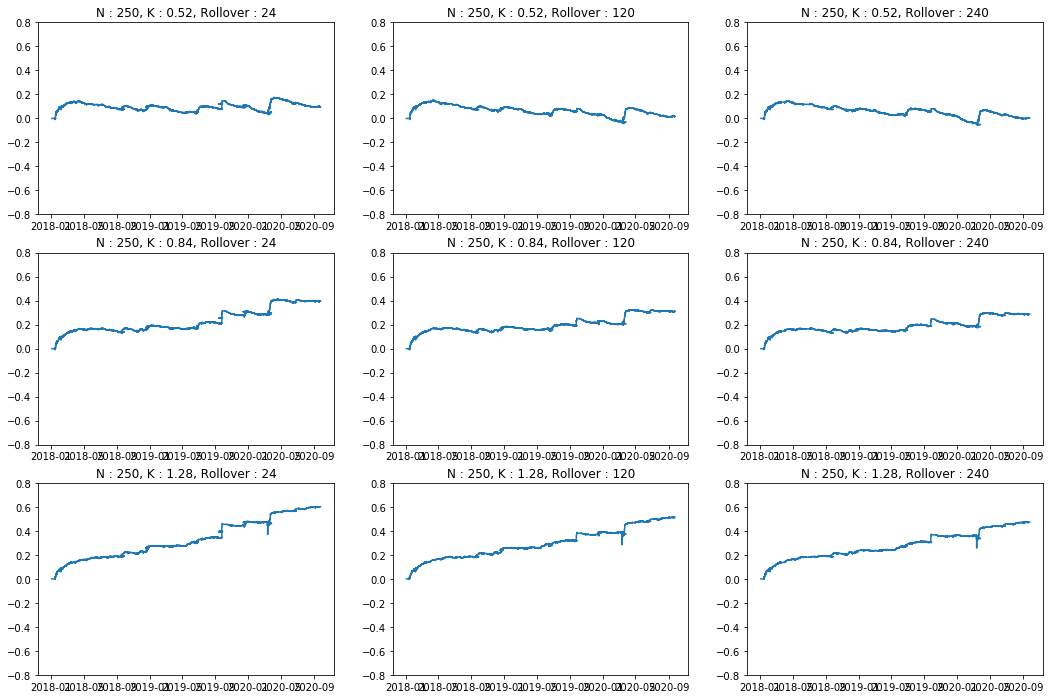

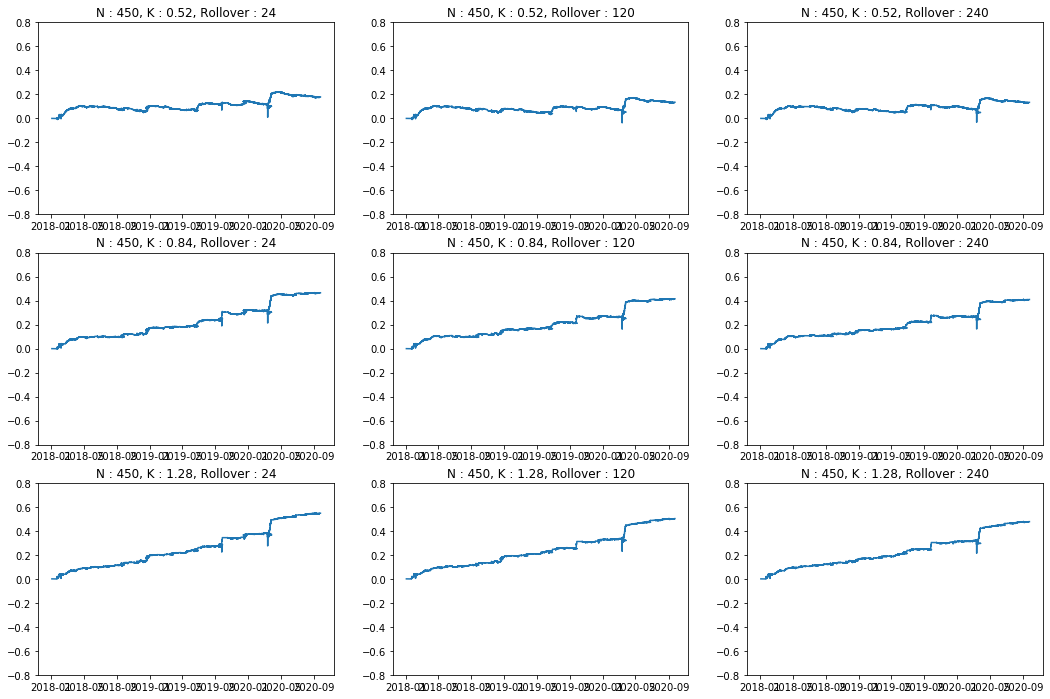

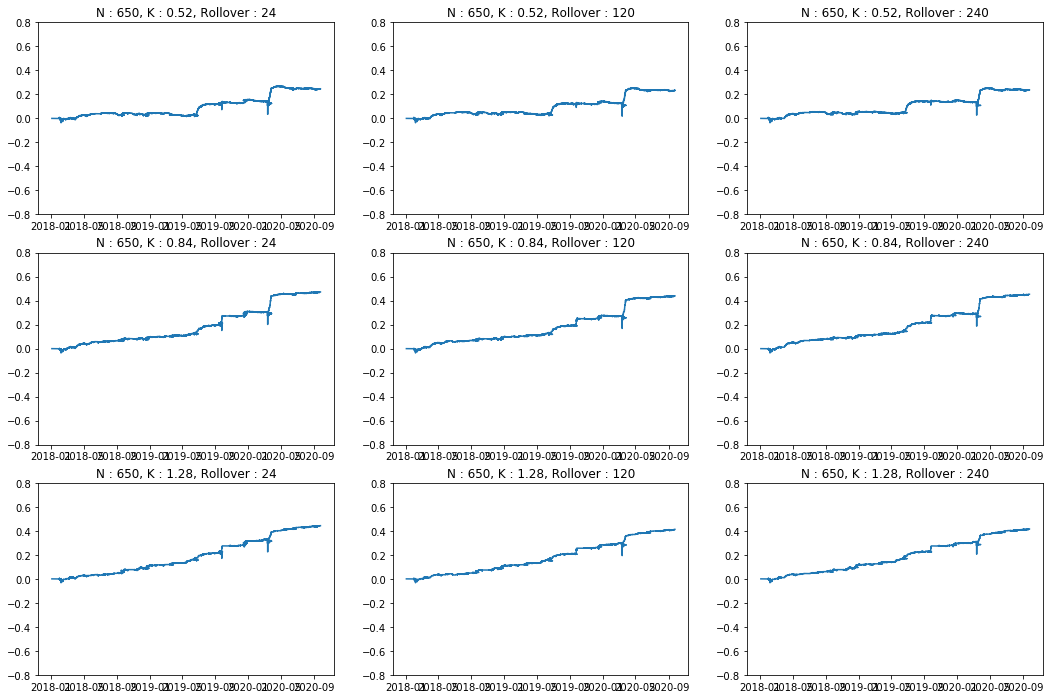

In [15]:
## Grid별 Return Time Series
for i in range(4):
    plt.figure(figsize=(3*6, 3*4))
    for j in range(1,9+1):        
        plt.subplot(3, 3, j)
        plt.title('N : {0}, K : {1}, Rollover : {2}'.format(grids[i*9+j-1][0], grids[i*9+j-1][1], grids[i*9+j-1][2]))
        plt.ylim(-0.8, 0.8)
        plt.plot(balance.iloc[:,i*9+j-1])
    plt.show()

In [16]:
compare[(compare['n']==650) & (compare['k']==1.28)]

,n,k,rollover,ret,std,sharpe_ratio
33,650,1.28,24,0.443724,0.143938,3.082748
34,650,1.28,120,0.412811,0.130670,3.159196
35,650,1.28,240,0.416375,0.131766,3.159968


## Parameter 설정 : 결과값의 변동성을 최소화하기 위해 N=650, K=1.28로 설정하고, Rollover는 Sharpe Ratio가 가장 큰 240으로 설정한다.